In [2]:
import DataFrames
import TimeSeries
import CSV
using Glob
using Dates
using Plots
import PyPlot
using LinearAlgebra
using IterativeSolvers
import Dierckx

In [3]:
dtg  = Dates.Date(2019,05,10)
YYYY = year(dtg) 
MM   = lpad(month(dtg),2,"0")
DD   = lpad(day(dtg),2,"0")

"10"

# Gaussian Process Regression

Assume data is multivariate normal 

$$\begin{bmatrix}
y \\
f_*
\end{bmatrix}
\sim \mathcal{N} \left(0, \begin{bmatrix}
K(X,X) + \sigma^2_o I & K(X,X_*) \\
K(X_*,X) & K(X_*,X_*)
\end{bmatrix}\right)$$

Then 

$$f_* | X, y, X_* =
K(X_*,X) (K(X,X) + \sigma^2_o I)^{-1} y$$



$$cov(f_*) = K(X_*,X_*) - K(X_*,X) \left(K(X,X) + \sigma^2_o I\right)^{-1} K(X,X_*)$$

In [5]:
archiveroot = "/media/roels/_disk2/netatmo/$YYYY/$MM/$DD"
outdir = "/media/roels/_disk2/netatmopng/"

"/media/roels/_disk2/netatmopng/"

In [6]:
df = DataFrames.DataFrame(id=String[], time_utc = Int64[], lat=Float64[], lon=Float64[], pressure=Float64[]  )

for filename in glob("$(YYYY)$(MM)$(DD)*.csv",archiveroot)   
  println("appending $filename" ) 
  append!(df,CSV.read(filename)) 
end   

appending /media/roels/_disk2/netatmo/2019/05/10/20190510T000501Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T001502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T002501Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T003501Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T004502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T005502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T010503Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T011502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T012504Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T013502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T014503Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T015502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T020503Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T021504Z.csv
appending /media/roe

appending /media/roels/_disk2/netatmo/2019/05/10/20190510T194503Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T195502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T200501Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T201502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T202503Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T203501Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T204502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T205502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T210502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T211502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T212502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T213502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T214502Z.csv
appending /media/roels/_disk2/netatmo/2019/05/10/20190510T215501Z.csv
appending /media/roe

dataframe size 144
dataframe size 144
dataframe size 144
dataframe size 144


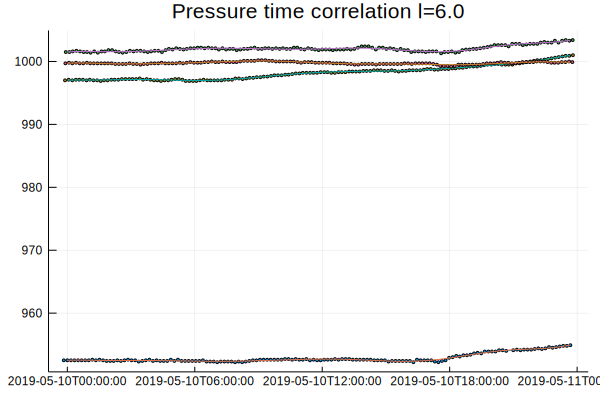

In [8]:
latmin = 58.0; latmax = 64.0; lonmin = 4.0; lonmax = 13.0
latmin = 59.9; latmax = 60; lonmin = 10.7; lonmax = 10.8

oslo  = df[(latmin .< df[:lat] .< latmax) .&  ( lonmin .< df[:lon] .< lonmax),:]

timerange = datetime2unix(Dates.DateTime(dtg)):60*10:datetime2unix(Dates.DateTime(dtg + Day(1)))
timerange = timerange[1:end-2] # avoid extrapolation beyond last time in :time_utc
RBF(t1,t2,l) = exp(-1/2*((t1-t2)/l)^2)


l=6.; # smoothing time in hours. 
sigmao = 0.001  
smooth = Array[]
RBFl(t1,t2) =  RBF(t1,t2,60*60*l)

p = plot(title="Pressure time correlation l=$l",legend=false)
for s1 in DataFrames.groupby(oslo,:id)[3:6]
   println("dataframe size $(size(s1,1))")
   #if size(s1,1)  < 70
   #   continue
   #end 
   s1u = unique(s1,:time_utc)   
   tf = Float64.(s1u[:time_utc])

   K    = [RBFl(t1,t2) for t1 in tf, t2 in tf]  
   K_s  = [RBFl(t1,t2) for t1 in tf, t2 in timerange]
   # K_ss = [RBFl(t1,t2) for t1 in timerange, t2 in timerange]
   K[diagind(K)] .= 1 + sigmao^2
   q,log= minres(K,s1u[:pressure],log=true)
   smooth = K_s'* q
   
   plot!(p,unix2datetime.(tf), s1u[:pressure],m=:o,markersize=1)
   plot!(p,unix2datetime.(timerange),smooth)
   
end
p

In [9]:

for t in timerange[1:2]
   println("Processing: $(unix2datetime(t))")
   y = Float64[]
   z = Float64[]
   x = Float64[]
   
   for s1 in DataFrames.groupby(oslo,:id)
     #  println("dataframe size $(size(s1,1))")
      if size(s1,1)  < 70
         continue
      end 
      s1u = unique(s1,:time_utc)  
      
      if !issorted(s1u)
         println("time not sorted in $(s1[:id][1])")
         continue
      end

      tf = Float64.(s1u[:time_utc])

      K    = [RBF(t1,t2,60*60*3) for t1 in tf, t2 in tf]  
      K_s  = [RBF(t1,t2,60*60*3) for t1 in tf, t2 in t]
      # K_ss = [RBFl(t1,t2) for t1 in timerange, t2 in timerange]
        
      K[diagind(K)] .= 1 + sigmao^2
      q,log = minres(K,s1u[:pressure],log=true)
             
      sp    = Dierckx.Spline1D(s1u[:time_utc],s1u[:pressure]) 
      
      sp1ma = K_s'* q
       
      append!(x, s1[:lon][1])
      append!(y, s1[:lat][1])    
      append!(z, sp(t) - sp1ma)         
     
   end
   badobs = (z.>2.) .| (z.<-2.)
   deleteat!(x,badobs)
   deleteat!(y,badobs)
   deleteat!(z,badobs)
    
    
   latlon =  zip(x,y) 
    
    
    
   K    = [RBF(xy1, xy2,1) for xy1 in latlon, xy2 in latlon]  
   K_s  = [RBF(xy1,y,1) for x in x, t2 in t]
       
   latrange = latmin:0.01:latmax
   lonrange = lonmin:0.01:lonmax
    
    
end

Processing: 2019-05-10T00:00:00
Processing: 2019-05-10T00:10:00


In [11]:
latlon =  zip(x,y) 
K    = [RBF(xy1, xy2,1) for xy1 in latlon, xy2 in latlon] 


UndefVarError: UndefVarError: x not defined